Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['B-LEGISLACAO', 'I-LEGISLACAO', 'O']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['B-LEGISLACAO', 'I-LEGISLACAO', 'O']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['B-LEGISLACAO', 'I-LEGISLACAO', 'O']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

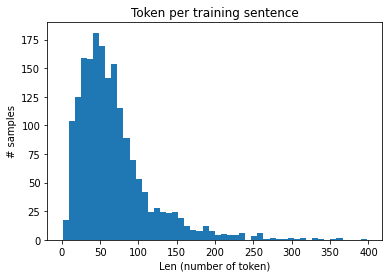

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

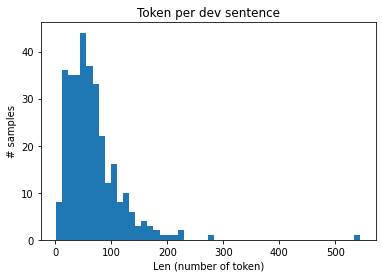

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

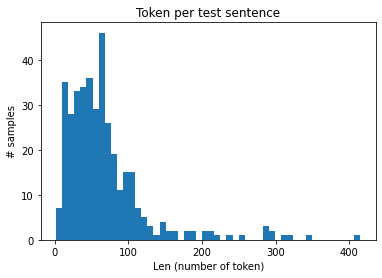

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

6067
interpuseram
0
B-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9724)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[13250, 9970, 6531, 5394, 11557, 12031, 3539, 5954, 4022, 5131, 10821, 10351, 5902, 12261, 3539, 1594, 5394, 478, 7289, 5847, 12309, 9685, 8066, 3058, 3539, 8524, 3459, 6180, 447, 10099, 1441, 2925, 8221, 7070, 12261, 5394, 96, 6486, 419, 9708, 5131, 11951, 6299, 5394, 10166, 11462, 11475, 3461, 9970, 7965, 826, 5705, 10110, 9970, 10740, 9970, 4307, 12359, 5131, 11475, 8066, 3058, 3539, 12355, 5229, 5040, 12355, 7289, 419, 1932, 5131, 11951, 7693, 9970]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2]
[9493, 6408, 3539, 7577, 5914, 2268, 12288, 5705, 4145, 5394, 11396, 144, 4850, 5740, 3480, 5394, 3868, 5394, 150, 9939, 3539, 4200, 7070, 9128, 6530, 2613, 8066, 2251, 8226, 5394, 10282, 6092, 3393, 7588, 7136, 11557, 10479, 10810, 5394, 6679, 9991, 8066, 4701, 3539, 8066, 2557, 3539, 12089, 5533, 8066, 6689, 5383, 5

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.6 MB/s 
     |████████████████████████████████| 6.6 MB 77.4 MB/s 
     |████████████████████████████████| 120 kB 88.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=48f9d0e4cdb6b497406184fa2adb848191fb58b19c1d1c22a1492df7a4bc2fa4
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[13250, 9970, 6531, 5394, 11557, 12031, 3539, 5954, 4022, 

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1758747100830078
Training loss epoch: 0.5631204843521118
Training accuracy epoch: 0.7731977857241304
Validating model...
Validation Loss: 0.3242283605393909
Validation Accuracy: 0.8992592247544916
Training epoch: 2
Training loss per 100 training steps: 0.3925567865371704
Training loss epoch: 0.2623001217842102
Training accuracy epoch: 0.910579962630985
Validating model...
Validation Loss: 0.1917183076341947
Validation Accuracy: 0.9264210222836643
Training epoch: 3
Training loss per 100 training steps: 0.1710214614868164
Training loss epoch: 0.13760217279195786
Training accuracy epoch: 0.959373108751528
Validating model...
Validation Loss: 0.12843568587586993
Validation Accuracy: 0.9632995763897305
Training epoch: 4
Training loss per 100 training steps: 0.08662848174571991
Training loss epoch: 0.06409025713801383
Training accuracy epoch: 0.983960162475927
Validating model...
Validation Loss: 0.09566925962766011
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06320731740561314
Validation Accuracy: 0.9865051523473479
Validation duration: 0.07717114999999998 minutes
F1-score (test): 90.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.92      0.90      1238

   micro avg       0.88      0.92      0.90      1238
   macro avg       0.88      0.92      0.90      1238
weighted avg       0.88      0.92      0.90      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.213808536529541
Training loss epoch: 0.5409642577171325
Training accuracy epoch: 0.76673826062892
Validating model...
Validation Loss: 0.34686294198036194
Validation Accuracy: 0.8964125073485915
Training epoch: 2
Training loss per 100 training steps: 0.24011416733264923
Training loss epoch: 0.2351939469575882
Training accuracy epoch: 0.91835342431934
Validating model...
Validation Loss: 0.19645387218112037
Validation Accuracy: 0.9483254955785034
Training epoch: 3
Training loss per 100 training steps: 0.17140065133571625
Training loss epoch: 0.14002153873443604
Training accuracy epoch: 0.9593346524857967
Validating model...
Validation Loss: 0.12617841416171618
Validation Accuracy: 0.9629862698017665
Training epoch: 4
Training loss per 100 training steps: 0.11935754120349884
Training loss epoch: 0.07032728269696235
Training accuracy epoch: 0.9819316994761795
Validating model...
Validation Loss: 0.0943953659208048
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05689308904887488
Validation Accuracy: 0.9847747796620535
Validation duration: 0.07694360000000036 minutes
F1-score (test): 87.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.88      0.88      1238

   micro avg       0.88      0.88      0.88      1238
   macro avg       0.88      0.88      0.88      1238
weighted avg       0.88      0.88      0.88      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0480163097381592
Training loss epoch: 0.5145246744155884
Training accuracy epoch: 0.8140309510942254
Validating model...
Validation Loss: 0.30372048843474614
Validation Accuracy: 0.892933845491507
Training epoch: 2
Training loss per 100 training steps: 0.2406236082315445
Training loss epoch: 0.220249804854393
Training accuracy epoch: 0.9245049037582399
Validating model...
Validation Loss: 0.1591275174702917
Validation Accuracy: 0.9513646045580305
Training epoch: 3
Training loss per 100 training steps: 0.18033376336097717
Training loss epoch: 0.11510078832507134
Training accuracy epoch: 0.964964335921698
Validating model...
Validation Loss: 0.12511166876980237
Validation Accuracy: 0.9508342890837514
Training epoch: 4
Training loss per 100 training steps: 0.11596900969743729
Training loss epoch: 0.06725911572575569
Training accuracy epoch: 0.9814722632876236
Validating model...
Validation Loss: 0.09161382345926194
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06972694761740665
Validation Accuracy: 0.9833935076697419
Validation duration: 0.07895038333333369 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.177601933479309
Training loss epoch: 0.5688744306564331
Training accuracy epoch: 0.7813201071170502
Validating model...
Validation Loss: 0.38364640800725847
Validation Accuracy: 0.8976633233323655
Training epoch: 2
Training loss per 100 training steps: 0.4252348244190216
Training loss epoch: 0.2715652763843536
Training accuracy epoch: 0.911446405386022
Validating model...
Validation Loss: 0.20006845110938662
Validation Accuracy: 0.9401675275602193
Training epoch: 3
Training loss per 100 training steps: 0.16991226375102997
Training loss epoch: 0.1670508623123169
Training accuracy epoch: 0.9525330973845705
Validating model...
Validation Loss: 0.1372923840369497
Validation Accuracy: 0.954759353005522
Training epoch: 4
Training loss per 100 training steps: 0.07553913444280624
Training loss epoch: 0.0950313463807106
Training accuracy epoch: 0.9697253353937167
Validating model...
Validation Loss: 0.10733155054705483
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06353199660467605
Validation Accuracy: 0.9828737915952148
Validation duration: 0.07752713333333361 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.88      0.87      1238

   micro avg       0.85      0.88      0.87      1238
   macro avg       0.85      0.88      0.87      1238
weighted avg       0.85      0.88      0.87      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.201682448387146
Training loss epoch: 0.565565550327301
Training accuracy epoch: 0.7687179353735897
Validating model...
Validation Loss: 0.35353043994733263
Validation Accuracy: 0.9021700324244389
Training epoch: 2
Training loss per 100 training steps: 0.39416420459747314
Training loss epoch: 0.2869457721710205
Training accuracy epoch: 0.9097410619106373
Validating model...
Validation Loss: 0.21090258303142728
Validation Accuracy: 0.9173520895004876
Training epoch: 3
Training loss per 100 training steps: 0.2532416582107544
Training loss epoch: 0.16955598145723344
Training accuracy epoch: 0.9410751045023652
Validating model...
Validation Loss: 0.136993313119525
Validation Accuracy: 0.957480520091576
Training epoch: 4
Training loss per 100 training steps: 0.08269203454256058
Training loss epoch: 0.07693180665373803
Training accuracy epoch: 0.9793081727547722
Validating model...
Validation Loss: 0.10518136168164867
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05987656341555218
Validation Accuracy: 0.9860224299621952
Validation duration: 0.07844596666666633 minutes
F1-score (test): 89.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.90      0.89      1238

   micro avg       0.89      0.90      0.89      1238
   macro avg       0.89      0.90      0.89      1238
weighted avg       0.89      0.90      0.89      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.074602484703064
Training loss epoch: 0.5214054465293885
Training accuracy epoch: 0.8008197246338753
Validating model...
Validation Loss: 0.30514446468580336
Validation Accuracy: 0.901161347121931
Training epoch: 2
Training loss per 100 training steps: 0.2629789710044861
Training loss epoch: 0.24001317322254181
Training accuracy epoch: 0.917469932406379
Validating model...
Validation Loss: 0.19022673723243533
Validation Accuracy: 0.9390453864000683
Training epoch: 3
Training loss per 100 training steps: 0.23032578825950623
Training loss epoch: 0.13717103004455566
Training accuracy epoch: 0.9567607852378345
Validating model...
Validation Loss: 0.12085848532262303
Validation Accuracy: 0.9567478411707193
Training epoch: 4
Training loss per 100 training steps: 0.06177776679396629
Training loss epoch: 0.07309568747878074
Training accuracy epoch: 0.9774917424611151
Validating model...
Validation Loss: 0.09003369013468425
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058894181585249804
Validation Accuracy: 0.9871273111136712
Validation duration: 0.07781228333333463 minutes
F1-score (test): 89.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.90      0.88      0.89      1238

   micro avg       0.90      0.88      0.89      1238
   macro avg       0.90      0.88      0.89      1238
weighted avg       0.90      0.88      0.89      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.180517315864563
Training loss epoch: 0.5403386533260346
Training accuracy epoch: 0.7757812900303132
Validating model...
Validation Loss: 0.31905330149900346
Validation Accuracy: 0.9008972921793563
Training epoch: 2
Training loss per 100 training steps: 0.30324220657348633
Training loss epoch: 0.2624906063079834
Training accuracy epoch: 0.9129112836876331
Validating model...
Validation Loss: 0.2013448945113591
Validation Accuracy: 0.9194754129365984
Training epoch: 3
Training loss per 100 training steps: 0.13635382056236267
Training loss epoch: 0.14853391349315642
Training accuracy epoch: 0.9513750826641786
Validating model...
Validation Loss: 0.12913561293057033
Validation Accuracy: 0.955811181964497
Training epoch: 4
Training loss per 100 training steps: 0.07025697082281113
Training loss epoch: 0.06337814703583718
Training accuracy epoch: 0.9847885244417182
Validating model...
Validation Loss: 0.100508247812589
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06514758616685867
Validation Accuracy: 0.9857957543660745
Validation duration: 0.07724093333333333 minutes
F1-score (test): 88.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.90      0.89      1238

   micro avg       0.88      0.90      0.89      1238
   macro avg       0.88      0.90      0.89      1238
weighted avg       0.88      0.90      0.89      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9987230896949768
Training loss epoch: 0.4769783139228821
Training accuracy epoch: 0.8375461473413944
Validating model...
Validation Loss: 0.2885601009641375
Validation Accuracy: 0.9013054577938054
Training epoch: 2
Training loss per 100 training steps: 0.4057427644729614
Training loss epoch: 0.23366069197654724
Training accuracy epoch: 0.918664519655015
Validating model...
Validation Loss: 0.17754383669013069
Validation Accuracy: 0.9350404540032916
Training epoch: 3
Training loss per 100 training steps: 0.1959129124879837
Training loss epoch: 0.11614956483244895
Training accuracy epoch: 0.965628728728386
Validating model...
Validation Loss: 0.09339144812630755
Validation Accuracy: 0.9719054584274845
Training epoch: 4
Training loss per 100 training steps: 0.07806362211704254
Training loss epoch: 0.04710309132933617
Training accuracy epoch: 0.9869750259212378
Validating model...
Validation Loss: 0.09584572272641319
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06904923155282934
Validation Accuracy: 0.9853158960890612
Validation duration: 0.0793282999999993 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.89      0.88      0.88      1238

   micro avg       0.89      0.88      0.88      1238
   macro avg       0.89      0.88      0.88      1238
weighted avg       0.89      0.88      0.88      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0476573705673218
Training loss epoch: 0.505853933095932
Training accuracy epoch: 0.8091296999884736
Validating model...
Validation Loss: 0.33054804447151365
Validation Accuracy: 0.893442646480419
Training epoch: 2
Training loss per 100 training steps: 0.4149567484855652
Training loss epoch: 0.24346163272857665
Training accuracy epoch: 0.9228955604961351
Validating model...
Validation Loss: 0.17338764951342628
Validation Accuracy: 0.9505727430200179
Training epoch: 3
Training loss per 100 training steps: 0.14022552967071533
Training loss epoch: 0.12779527753591538
Training accuracy epoch: 0.961422659632475
Validating model...
Validation Loss: 0.13254424397434508
Validation Accuracy: 0.9542695067141512
Training epoch: 4
Training loss per 100 training steps: 0.09462620317935944
Training loss epoch: 0.07171670645475388
Training accuracy epoch: 0.9797066346629789
Validating model...
Validation Loss: 0.12609949016145297
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06411193528523047
Validation Accuracy: 0.9840784007533682
Validation duration: 0.07837248333333377 minutes
F1-score (test): 87.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.91      0.88      1238

   micro avg       0.85      0.91      0.88      1238
   macro avg       0.85      0.91      0.88      1238
weighted avg       0.85      0.91      0.88      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0178369283676147
Training loss epoch: 0.5056433409452439
Training accuracy epoch: 0.8097272120872484
Validating model...
Validation Loss: 0.24515536427497864
Validation Accuracy: 0.90410433543526
Training epoch: 2
Training loss per 100 training steps: 0.18344740569591522
Training loss epoch: 0.21221671253442764
Training accuracy epoch: 0.9275457676916139
Validating model...
Validation Loss: 0.17275927428688323
Validation Accuracy: 0.9411750977669412
Training epoch: 3
Training loss per 100 training steps: 0.14072220027446747
Training loss epoch: 0.09674098789691925
Training accuracy epoch: 0.9731651688039216
Validating model...
Validation Loss: 0.10066735717867102
Validation Accuracy: 0.9660407950442951
Training epoch: 4
Training loss per 100 training steps: 0.04743529483675957
Training loss epoch: 0.0402094479650259
Training accuracy epoch: 0.9912206762714828
Validating model...
Validation Loss: 0.09690919110462778
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06428977160248905
Validation Accuracy: 0.9851887302620194
Validation duration: 0.07898941666666891 minutes
F1-score (test): 89.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.90      1238

   micro avg       0.88      0.91      0.90      1238
   macro avg       0.88      0.91      0.90      1238
weighted avg       0.88      0.91      0.90      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2866398096084595
Training loss epoch: 0.46705710887908936
Training accuracy epoch: 0.7920430840061307
Validating model...
Validation Loss: 0.2794992391552244
Validation Accuracy: 0.9071795330034482
Training epoch: 2
Training loss per 100 training steps: 0.3721763789653778
Training loss epoch: 0.21578449010849
Training accuracy epoch: 0.9137236627437032
Validating model...
Validation Loss: 0.20765019421066558
Validation Accuracy: 0.9287046982458309
Training epoch: 3
Training loss per 100 training steps: 0.1497899889945984
Training loss epoch: 0.12053046481949943
Training accuracy epoch: 0.963651062616813
Validating model...
Validation Loss: 0.1170857007659617
Validation Accuracy: 0.9627421588038225
Training epoch: 4
Training loss per 100 training steps: 0.07943109422922134
Training loss epoch: 0.057298424520662854
Training accuracy epoch: 0.9843576047255628
Validating model...
Validation Loss: 0.11232081374951772
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06677999867436786
Validation Accuracy: 0.9846386612257714
Validation duration: 0.08012506666666468 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.87      0.88      1238

   micro avg       0.88      0.87      0.88      1238
   macro avg       0.88      0.87      0.88      1238
weighted avg       0.88      0.87      0.88      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.053879737854004
Training loss epoch: 0.42962258202689035
Training accuracy epoch: 0.8315400638066126
Validating model...
Validation Loss: 0.22033601041351045
Validation Accuracy: 0.9224616579303085
Training epoch: 2
Training loss per 100 training steps: 0.16948671638965607
Training loss epoch: 0.15432075411081314
Training accuracy epoch: 0.9485011857341074
Validating model...
Validation Loss: 0.11890869215130806
Validation Accuracy: 0.9620540592693338
Training epoch: 3
Training loss per 100 training steps: 0.21515251696109772
Training loss epoch: 0.08067040983587503
Training accuracy epoch: 0.9771612948431424
Validating model...
Validation Loss: 0.08193754874879405
Validation Accuracy: 0.9759945207196136
Training epoch: 4
Training loss per 100 training steps: 0.039095599204301834
Training loss epoch: 0.03157594161374228
Training accuracy epoch: 0.991309403486164
Validating model...
Validation Loss: 0.12682817858599482
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06460523442365229
Validation Accuracy: 0.9846242388185814
Validation duration: 0.07773389999999836 minutes
F1-score (test): 87.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1448156833648682
Training loss epoch: 0.5220294381890979
Training accuracy epoch: 0.8129908298844671
Validating model...
Validation Loss: 0.3797712936287835
Validation Accuracy: 0.8972364053018147
Training epoch: 2
Training loss per 100 training steps: 0.38243818283081055
Training loss epoch: 0.2568673810788563
Training accuracy epoch: 0.9167703951170696
Validating model...
Validation Loss: 0.21431582456543333
Validation Accuracy: 0.9078272745179206
Training epoch: 3
Training loss per 100 training steps: 0.21781441569328308
Training loss epoch: 0.174537150987557
Training accuracy epoch: 0.9355153468167166
Validating model...
Validation Loss: 0.14859758441646895
Validation Accuracy: 0.9366436214270346
Training epoch: 4
Training loss per 100 training steps: 0.07681997865438461
Training loss epoch: 0.0948849091572421
Training accuracy epoch: 0.9681262917757948
Validating model...
Validation Loss: 0.09006218984723091
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05702009024874618
Validation Accuracy: 0.9854530705687868
Validation duration: 0.07777150000000195 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.88      0.87      1238

   micro avg       0.87      0.88      0.87      1238
   macro avg       0.87      0.88      0.87      1238
weighted avg       0.87      0.88      0.87      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.003036618232727
Training loss epoch: 0.4075532683304378
Training accuracy epoch: 0.8546561254735234
Validating model...
Validation Loss: 0.21974864531131016
Validation Accuracy: 0.9143060959245972
Training epoch: 2
Training loss per 100 training steps: 0.3141932189464569
Training loss epoch: 0.16815821932894842
Training accuracy epoch: 0.9421350732029712
Validating model...
Validation Loss: 0.11141772444049518
Validation Accuracy: 0.9648422800626835
Training epoch: 3
Training loss per 100 training steps: 0.10311384499073029
Training loss epoch: 0.06714151693241936
Training accuracy epoch: 0.9793197949219499
Validating model...
Validation Loss: 0.08669772673220862
Validation Accuracy: 0.9744794783833051
Training epoch: 4
Training loss per 100 training steps: 0.06633276492357254
Training loss epoch: 0.03377932256885937
Training accuracy epoch: 0.9919015961045581
Validating model...
Validation Loss: 0.11088336489739872
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06328840584804614
Validation Accuracy: 0.9847102512140724
Validation duration: 0.07613965000000084 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.85      0.86      1238

   micro avg       0.87      0.85      0.86      1238
   macro avg       0.87      0.85      0.86      1238
weighted avg       0.87      0.85      0.86      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9476509690284729
Training loss epoch: 0.4384954401424953
Training accuracy epoch: 0.8624876387018965
Validating model...
Validation Loss: 0.26016161768209367
Validation Accuracy: 0.9010631251094748
Training epoch: 2
Training loss per 100 training steps: 0.2119172066450119
Training loss epoch: 0.18341038482529776
Training accuracy epoch: 0.9400060543601786
Validating model...
Validation Loss: 0.13324197842961266
Validation Accuracy: 0.958940069291343
Training epoch: 3
Training loss per 100 training steps: 0.13665015995502472
Training loss epoch: 0.08260437047907285
Training accuracy epoch: 0.9732432876446434
Validating model...
Validation Loss: 0.10382333681696937
Validation Accuracy: 0.9659177865549695
Training epoch: 4
Training loss per 100 training steps: 0.04621695727109909
Training loss epoch: 0.04233442007430962
Training accuracy epoch: 0.9869286406533918
Validating model...
Validation Loss: 0.08548985270872003
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07091061487638702
Validation Accuracy: 0.9811057072316589
Validation duration: 0.07775288333333492 minutes
F1-score (test): 83.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.78      0.89      0.83      1238

   micro avg       0.78      0.89      0.83      1238
   macro avg       0.78      0.89      0.83      1238
weighted avg       0.78      0.89      0.83      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0757800340652466
Training loss epoch: 0.4373317850487573
Training accuracy epoch: 0.8457789200164963
Validating model...
Validation Loss: 0.27577645154226393
Validation Accuracy: 0.8957243618234646
Training epoch: 2
Training loss per 100 training steps: 0.2187134027481079
Training loss epoch: 0.18002966046333313
Training accuracy epoch: 0.934462817892861
Validating model...
Validation Loss: 0.14109127897591817
Validation Accuracy: 0.9496421558481061
Training epoch: 3
Training loss per 100 training steps: 0.21508783102035522
Training loss epoch: 0.08847394532391004
Training accuracy epoch: 0.9704846480029302
Validating model...
Validation Loss: 0.1025204931696256
Validation Accuracy: 0.9644937830757127
Training epoch: 4
Training loss per 100 training steps: 0.07217461615800858
Training loss epoch: 0.03854100898440395
Training accuracy epoch: 0.9885369965435936
Validating model...
Validation Loss: 0.10375333790268217
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06236183821844558
Validation Accuracy: 0.986530959232752
Validation duration: 0.07782078333333402 minutes
F1-score (test): 88.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.92      0.89      1238

   micro avg       0.86      0.92      0.89      1238
   macro avg       0.86      0.92      0.89      1238
weighted avg       0.86      0.92      0.89      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9610329866409302
Training loss epoch: 0.41039456852844786
Training accuracy epoch: 0.8593757499149077
Validating model...
Validation Loss: 0.2281420493409747
Validation Accuracy: 0.910589172538065
Training epoch: 2
Training loss per 100 training steps: 0.15220706164836884
Training loss epoch: 0.14414306676813535
Training accuracy epoch: 0.9529784982919669
Validating model...
Validation Loss: 0.1234278054464431
Validation Accuracy: 0.9587495832262308
Training epoch: 3
Training loss per 100 training steps: 0.09585004299879074
Training loss epoch: 0.11112901036228452
Training accuracy epoch: 0.9635391028061792
Validating model...
Validation Loss: 0.11187036406426203
Validation Accuracy: 0.9601465860306779
Training epoch: 4
Training loss per 100 training steps: 0.0586373507976532
Training loss epoch: 0.05853674773659025
Training accuracy epoch: 0.9793712531400642
Validating model...
Validation Loss: 0.09244774796423458
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05777902567448715
Validation Accuracy: 0.9827057629073095
Validation duration: 0.077957733333335 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.83      0.84      1238

   micro avg       0.84      0.83      0.84      1238
   macro avg       0.84      0.83      0.84      1238
weighted avg       0.84      0.83      0.84      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3684734106063843
Training loss epoch: 0.5447910130023956
Training accuracy epoch: 0.791481074320106
Validating model...
Validation Loss: 0.348090641555332
Validation Accuracy: 0.8891859460743331
Training epoch: 2
Training loss per 100 training steps: 0.25666141510009766
Training loss epoch: 0.24006875497954233
Training accuracy epoch: 0.9141809244541258
Validating model...
Validation Loss: 0.17793130342449462
Validation Accuracy: 0.9425354589533064
Training epoch: 3
Training loss per 100 training steps: 0.20470665395259857
Training loss epoch: 0.13401277789047786
Training accuracy epoch: 0.9530164932395876
Validating model...
Validation Loss: 0.11637010602723985
Validation Accuracy: 0.9623163816983835
Training epoch: 4
Training loss per 100 training steps: 0.11403975635766983
Training loss epoch: 0.08321503070848328
Training accuracy epoch: 0.967310808606899
Validating model...
Validation Loss: 0.10922295529217947
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0657133402225251
Validation Accuracy: 0.9827307955343084
Validation duration: 0.07825530000000072 minutes
F1-score (test): 85.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.87      0.85      1238

   micro avg       0.84      0.87      0.85      1238
   macro avg       0.84      0.87      0.85      1238
weighted avg       0.84      0.87      0.85      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0684939622879028
Training loss epoch: 0.46148209486688885
Training accuracy epoch: 0.8242361600850053
Validating model...
Validation Loss: 0.3103029273805164
Validation Accuracy: 0.8942484205244865
Training epoch: 2
Training loss per 100 training steps: 0.27996692061424255
Training loss epoch: 0.19200462528637477
Training accuracy epoch: 0.9329790601867989
Validating model...
Validation Loss: 0.14529181307270414
Validation Accuracy: 0.9536229610312955
Training epoch: 3
Training loss per 100 training steps: 0.11819864809513092
Training loss epoch: 0.09558256076914924
Training accuracy epoch: 0.9732827596205464
Validating model...
Validation Loss: 0.10059155357469406
Validation Accuracy: 0.9664956773144363
Training epoch: 4
Training loss per 100 training steps: 0.07686413079500198
Training loss epoch: 0.04568203751529966
Training accuracy epoch: 0.9891587197543298
Validating model...
Validation Loss: 0.07719434119228806
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05604402511380613
Validation Accuracy: 0.9862614384791631
Validation duration: 0.07623598333333348 minutes
F1-score (test): 88.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.90      0.88      1238

   micro avg       0.87      0.90      0.88      1238
   macro avg       0.87      0.90      0.88      1238
weighted avg       0.87      0.90      0.88      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2829681634902954
Training loss epoch: 0.4828168111188071
Training accuracy epoch: 0.7990652693383665
Validating model...
Validation Loss: 0.2648713375840868
Validation Accuracy: 0.897939715597996
Training epoch: 2
Training loss per 100 training steps: 0.27622586488723755
Training loss epoch: 0.18357436678239278
Training accuracy epoch: 0.9390724160727356
Validating model...
Validation Loss: 0.1622569046559788
Validation Accuracy: 0.9520806845615685
Training epoch: 3
Training loss per 100 training steps: 0.20270080864429474
Training loss epoch: 0.08582516972507749
Training accuracy epoch: 0.9731459397113852
Validating model...
Validation Loss: 0.09629292715163458
Validation Accuracy: 0.9658313110519396
Training epoch: 4
Training loss per 100 training steps: 0.04748053103685379
Training loss epoch: 0.039194319929395406
Training accuracy epoch: 0.9887278821671853
Validating model...
Validation Loss: 0.08243528709170364
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06133785471320152
Validation Accuracy: 0.9849264523460012
Validation duration: 0.08029891666666723 minutes
F1-score (test): 88.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.91      0.89      1238

   micro avg       0.86      0.91      0.89      1238
   macro avg       0.86      0.91      0.89      1238
weighted avg       0.86      0.91      0.89      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1763229370117188
Training loss epoch: 0.4207279421389103
Training accuracy epoch: 0.8245245589952305
Validating model...
Validation Loss: 0.20451170347985767
Validation Accuracy: 0.9309062356903943
Training epoch: 2
Training loss per 100 training steps: 0.18679720163345337
Training loss epoch: 0.15892172791063786
Training accuracy epoch: 0.9443029407038152
Validating model...
Validation Loss: 0.10911887289867514
Validation Accuracy: 0.9634410289501002
Training epoch: 3
Training loss per 100 training steps: 0.07773950695991516
Training loss epoch: 0.06462011765688658
Training accuracy epoch: 0.9800708106832352
Validating model...
Validation Loss: 0.23089363763020151
Validation Accuracy: 0.9271359987484215
Training epoch: 4
Training loss per 100 training steps: 0.037238188087940216
Training loss epoch: 0.0335949290310964
Training accuracy epoch: 0.9905519037892175
Validating model...
Validation Loss: 0.10542823188006878
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0690823399151365
Validation Accuracy: 0.9842397750091955
Validation duration: 0.07709866666667343 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.91      0.88      1238

   micro avg       0.85      0.91      0.88      1238
   macro avg       0.85      0.91      0.88      1238
weighted avg       0.85      0.91      0.88      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1188801527023315
Training loss epoch: 0.4356005862355232
Training accuracy epoch: 0.8397310898433485
Validating model...
Validation Loss: 0.21596196932452066
Validation Accuracy: 0.928652126802993
Training epoch: 2
Training loss per 100 training steps: 0.14849498867988586
Training loss epoch: 0.15606461558490992
Training accuracy epoch: 0.9530531038511337
Validating model...
Validation Loss: 0.13276777203593934
Validation Accuracy: 0.9570310057517579
Training epoch: 3
Training loss per 100 training steps: 0.16923782229423523
Training loss epoch: 0.07719226833432913
Training accuracy epoch: 0.9737949692270854
Validating model...
Validation Loss: 0.09017087590126764
Validation Accuracy: 0.9740943829369219
Training epoch: 4
Training loss per 100 training steps: 0.025481048971414566
Training loss epoch: 0.031178991310298443
Training accuracy epoch: 0.9922665797546854
Validating model...
Validation Loss: 0.07441812486476487
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05978621984831989
Validation Accuracy: 0.9844071913906901
Validation duration: 0.07656776666666852 minutes
F1-score (test): 85.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.87      0.86      1238

   micro avg       0.85      0.87      0.86      1238
   macro avg       0.85      0.87      0.86      1238
weighted avg       0.85      0.87      0.86      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3726716041564941
Training loss epoch: 0.5149713084101677
Training accuracy epoch: 0.803442979261405
Validating model...
Validation Loss: 0.29606627779347555
Validation Accuracy: 0.8935680171145841
Training epoch: 2
Training loss per 100 training steps: 0.30954471230506897
Training loss epoch: 0.20369040220975876
Training accuracy epoch: 0.9287394461366217
Validating model...
Validation Loss: 0.1431605549795287
Validation Accuracy: 0.9507286501298855
Training epoch: 3
Training loss per 100 training steps: 0.09584938734769821
Training loss epoch: 0.10652278596535325
Training accuracy epoch: 0.9635903240525394
Validating model...
Validation Loss: 0.09243622275867633
Validation Accuracy: 0.9720645197702021
Training epoch: 4
Training loss per 100 training steps: 0.09927523881196976
Training loss epoch: 0.055238629691302776
Training accuracy epoch: 0.9840496498561936
Validating model...
Validation Loss: 0.08495439837376277
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07141273849022885
Validation Accuracy: 0.9825517430065082
Validation duration: 0.07890208333333248 minutes
F1-score (test): 85.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.88      0.85      1238

   micro avg       0.82      0.88      0.85      1238
   macro avg       0.82      0.88      0.85      1238
weighted avg       0.82      0.88      0.85      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.104958415031433
Training loss epoch: 0.4264268483966589
Training accuracy epoch: 0.8432750967653284
Validating model...
Validation Loss: 0.26343600168114617
Validation Accuracy: 0.8994313987500374
Training epoch: 2
Training loss per 100 training steps: 0.15929579734802246
Training loss epoch: 0.17893998231738806
Training accuracy epoch: 0.933835453637819
Validating model...
Validation Loss: 0.13542320189021884
Validation Accuracy: 0.9542160190444446
Training epoch: 3
Training loss per 100 training steps: 0.13134875893592834
Training loss epoch: 0.08724334090948105
Training accuracy epoch: 0.9723744350198874
Validating model...
Validation Loss: 0.08546903183949846
Validation Accuracy: 0.9758827238764608
Training epoch: 4
Training loss per 100 training steps: 0.04508814960718155
Training loss epoch: 0.0451183901168406
Training accuracy epoch: 0.987377386995238
Validating model...
Validation Loss: 0.0818947430788761
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07698315273349483
Validation Accuracy: 0.9856779566823026
Validation duration: 0.07868871666667018 minutes
F1-score (test): 89.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.88      0.91      0.89      1238

   micro avg       0.88      0.91      0.89      1238
   macro avg       0.88      0.91      0.89      1238
weighted avg       0.88      0.91      0.89      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.120534896850586
Training loss epoch: 0.44181056320667267
Training accuracy epoch: 0.8363771879057544
Validating model...
Validation Loss: 0.23632900629724776
Validation Accuracy: 0.9158423664741746
Training epoch: 2
Training loss per 100 training steps: 0.2523425221443176
Training loss epoch: 0.17929360829293728
Training accuracy epoch: 0.9329269855382688
Validating model...
Validation Loss: 0.13938761431546437
Validation Accuracy: 0.9533379859938226
Training epoch: 3
Training loss per 100 training steps: 0.09011831879615784
Training loss epoch: 0.08091986645013094
Training accuracy epoch: 0.9740130751261575
Validating model...
Validation Loss: 0.09887988980682123
Validation Accuracy: 0.9699988855327103
Training epoch: 4
Training loss per 100 training steps: 0.01712285727262497
Training loss epoch: 0.035506403306499124
Training accuracy epoch: 0.9899987548314074
Validating model...
Validation Loss: 0.08986391827818893
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06344612191120784
Validation Accuracy: 0.9818986171411136
Validation duration: 0.07814656666666905 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.91      0.87      1238

   micro avg       0.82      0.91      0.87      1238
   macro avg       0.82      0.91      0.87      1238
weighted avg       0.82      0.91      0.87      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2037653923034668
Training loss epoch: 0.4633711874485016
Training accuracy epoch: 0.8185669760388916
Validating model...
Validation Loss: 0.2418899096193768
Validation Accuracy: 0.9092955541631509
Training epoch: 2
Training loss per 100 training steps: 0.2325798124074936
Training loss epoch: 0.1773221269249916
Training accuracy epoch: 0.9391726259409857
Validating model...
Validation Loss: 0.13324108666607312
Validation Accuracy: 0.9590885701694195
Training epoch: 3
Training loss per 100 training steps: 0.09289885312318802
Training loss epoch: 0.0825315429829061
Training accuracy epoch: 0.9733098948866906
Validating model...
Validation Loss: 0.08794419542841968
Validation Accuracy: 0.971816026883697
Training epoch: 4
Training loss per 100 training steps: 0.029429558664560318
Training loss epoch: 0.03750629164278507
Training accuracy epoch: 0.9894101085737728
Validating model...
Validation Loss: 0.07879384154719966
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07279884155529241
Validation Accuracy: 0.9809023712778094
Validation duration: 0.077170700000003 minutes
F1-score (test): 83.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.79      0.90      0.84      1238

   micro avg       0.79      0.90      0.84      1238
   macro avg       0.79      0.90      0.84      1238
weighted avg       0.79      0.90      0.84      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0444879531860352
Training loss epoch: 0.4218876864761114
Training accuracy epoch: 0.8552397709150354
Validating model...
Validation Loss: 0.2176241718587421
Validation Accuracy: 0.9360376315447173
Training epoch: 2
Training loss per 100 training steps: 0.23807720839977264
Training loss epoch: 0.14014413114637136
Training accuracy epoch: 0.95434159206298
Validating model...
Validation Loss: 0.1277343410821188
Validation Accuracy: 0.954554913583957
Training epoch: 3
Training loss per 100 training steps: 0.10553700476884842
Training loss epoch: 0.060052731772884727
Training accuracy epoch: 0.9790776599975572
Validating model...
Validation Loss: 0.09136794445415337
Validation Accuracy: 0.971310555234679
Training epoch: 4
Training loss per 100 training steps: 0.025871505960822105
Training loss epoch: 0.025780476164072752
Training accuracy epoch: 0.9915931660964123
Validating model...
Validation Loss: 0.06402080998911212
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.056190063167984285
Validation Accuracy: 0.9833226625887801
Validation duration: 0.07821561666667094 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.88      0.87      1238

   micro avg       0.85      0.88      0.87      1238
   macro avg       0.85      0.88      0.87      1238
weighted avg       0.85      0.88      0.87      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3103508949279785
Training loss epoch: 0.469051580876112
Training accuracy epoch: 0.8093217997643898
Validating model...
Validation Loss: 0.22760949177401407
Validation Accuracy: 0.9090104491966322
Training epoch: 2
Training loss per 100 training steps: 0.20369045436382294
Training loss epoch: 0.15036098100245
Training accuracy epoch: 0.9504463870675683
Validating model...
Validation Loss: 0.1396948535527502
Validation Accuracy: 0.9517865151133146
Training epoch: 3
Training loss per 100 training steps: 0.09358645230531693
Training loss epoch: 0.07300127181224525
Training accuracy epoch: 0.9737567972819483
Validating model...
Validation Loss: 0.11187641109739031
Validation Accuracy: 0.9616741610213072
Training epoch: 4
Training loss per 100 training steps: 0.0444951206445694
Training loss epoch: 0.03839625185355544
Training accuracy epoch: 0.9882960491080927
Validating model...
Validation Loss: 0.07795250425780458
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06963567381414275
Validation Accuracy: 0.9847570893036396
Validation duration: 0.07644034999999955 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.161077618598938
Training loss epoch: 0.4428003504872322
Training accuracy epoch: 0.833289300244412
Validating model...
Validation Loss: 0.25104151169459027
Validation Accuracy: 0.9035493422957762
Training epoch: 2
Training loss per 100 training steps: 0.23180072009563446
Training loss epoch: 0.16693054791539907
Training accuracy epoch: 0.9419524395079532
Validating model...
Validation Loss: 0.13574958592653275
Validation Accuracy: 0.9573614979147509
Training epoch: 3
Training loss per 100 training steps: 0.13093742728233337
Training loss epoch: 0.08766050217673182
Training accuracy epoch: 0.9707169106917841
Validating model...
Validation Loss: 0.09047097748234159
Validation Accuracy: 0.9732374264171296
Training epoch: 4
Training loss per 100 training steps: 0.06527557224035263
Training loss epoch: 0.04788011126220226
Training accuracy epoch: 0.9848393300054824
Validating model...
Validation Loss: 0.07606887941559155
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05723310417185227
Validation Accuracy: 0.9848653853056263
Validation duration: 0.07843853333332997 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.87      0.87      0.87      1238

   micro avg       0.87      0.87      0.87      1238
   macro avg       0.87      0.87      0.87      1238
weighted avg       0.87      0.87      0.87      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1553995609283447
Training loss epoch: 0.43882715702056885
Training accuracy epoch: 0.8332115170920988
Validating model...
Validation Loss: 0.2425742656702087
Validation Accuracy: 0.9020323652333033
Training epoch: 2
Training loss per 100 training steps: 0.23853768408298492
Training loss epoch: 0.18218805268406868
Training accuracy epoch: 0.9376907498843341
Validating model...
Validation Loss: 0.12457222917250224
Validation Accuracy: 0.9550100249764348
Training epoch: 3
Training loss per 100 training steps: 0.07460109889507294
Training loss epoch: 0.07238440634682775
Training accuracy epoch: 0.977600997359225
Validating model...
Validation Loss: 0.12095348235397112
Validation Accuracy: 0.9601200955941231
Training epoch: 4
Training loss per 100 training steps: 0.07147931307554245
Training loss epoch: 0.037972873251419514
Training accuracy epoch: 0.9895880294267965
Validating model...
Validation Loss: 0.10238584060044516
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06636371843827267
Validation Accuracy: 0.9843219087151485
Validation duration: 0.07799141666666856 minutes
F1-score (test): 88.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.92      0.88      1238

   micro avg       0.85      0.92      0.88      1238
   macro avg       0.85      0.92      0.88      1238
weighted avg       0.85      0.92      0.88      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1287423372268677
Training loss epoch: 0.4426351288954417
Training accuracy epoch: 0.837265505030882
Validating model...
Validation Loss: 0.23825979445661818
Validation Accuracy: 0.9163700657824934
Training epoch: 2
Training loss per 100 training steps: 0.21292775869369507
Training loss epoch: 0.17539984401729372
Training accuracy epoch: 0.9376838920749417
Validating model...
Validation Loss: 0.12136572439755712
Validation Accuracy: 0.9603039046256431
Training epoch: 3
Training loss per 100 training steps: 0.07545885443687439
Training loss epoch: 0.0839804969727993
Training accuracy epoch: 0.9729506093215432
Validating model...
Validation Loss: 0.09142495727255232
Validation Accuracy: 0.9733455189535711
Training epoch: 4
Training loss per 100 training steps: 0.025741010904312134
Training loss epoch: 0.03940759143895573
Training accuracy epoch: 0.9878585263661217
Validating model...
Validation Loss: 0.0733346532742005
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07278673490509391
Validation Accuracy: 0.9783827620157083
Validation duration: 0.07930558333333314 minutes
F1-score (test): 78.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.75      0.82      0.78      1238

   micro avg       0.75      0.82      0.78      1238
   macro avg       0.75      0.82      0.78      1238
weighted avg       0.75      0.82      0.78      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.5057262182235718
Training loss epoch: 0.4738115949763192
Training accuracy epoch: 0.8188481544990394
Validating model...
Validation Loss: 0.26679882194314686
Validation Accuracy: 0.895784631204817
Training epoch: 2
Training loss per 100 training steps: 0.28571775555610657
Training loss epoch: 0.18775999546051025
Training accuracy epoch: 0.9335390034677241
Validating model...
Validation Loss: 0.1563416471083959
Validation Accuracy: 0.9459242518395798
Training epoch: 3
Training loss per 100 training steps: 0.15998968482017517
Training loss epoch: 0.09353388100862503
Training accuracy epoch: 0.97015309921131
Validating model...
Validation Loss: 0.11850373375983465
Validation Accuracy: 0.9610592835599067
Training epoch: 4
Training loss per 100 training steps: 0.10654023289680481
Training loss epoch: 0.04972357478820615
Training accuracy epoch: 0.9839055460248507
Validating model...
Validation Loss: 0.08775368412690503
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06151311743694047
Validation Accuracy: 0.9854727843832108
Validation duration: 0.07861963333333127 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9468685984611511
Training loss epoch: 0.3830706841415829
Training accuracy epoch: 0.8821589642556088
Validating model...
Validation Loss: 0.22823798372631982
Validation Accuracy: 0.9110198012075331
Training epoch: 2
Training loss per 100 training steps: 0.19351494312286377
Training loss epoch: 0.1467230717341105
Training accuracy epoch: 0.9445199198646095
Validating model...
Validation Loss: 0.1257599170009295
Validation Accuracy: 0.9607702977198317
Training epoch: 3
Training loss per 100 training steps: 0.0870862603187561
Training loss epoch: 0.06030638598733478
Training accuracy epoch: 0.981417400881967
Validating model...
Validation Loss: 0.09657533174114567
Validation Accuracy: 0.973703535184529
Training epoch: 4
Training loss per 100 training steps: 0.013574783690273762
Training loss epoch: 0.02443176745954487
Training accuracy epoch: 0.9941573214401943
Validating model...
Validation Loss: 0.08628535483564649
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07233480084687471
Validation Accuracy: 0.9798240063997886
Validation duration: 0.07762698333332689 minutes
F1-score (test): 78.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.76      0.81      0.78      1238

   micro avg       0.76      0.81      0.78      1238
   macro avg       0.76      0.81      0.78      1238
weighted avg       0.76      0.81      0.78      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0908180475234985
Training loss epoch: 0.3856405384010739
Training accuracy epoch: 0.8507053272309493
Validating model...
Validation Loss: 0.20651163231758846
Validation Accuracy: 0.9112455373983815
Training epoch: 2
Training loss per 100 training steps: 0.23699605464935303
Training loss epoch: 0.14808485408624014
Training accuracy epoch: 0.9485534398669265
Validating model...
Validation Loss: 0.10307193990974199
Validation Accuracy: 0.9671184948566588
Training epoch: 3
Training loss per 100 training steps: 0.09273740649223328
Training loss epoch: 0.05627624359395769
Training accuracy epoch: 0.9845117140001322
Validating model...
Validation Loss: 0.07989932871645405
Validation Accuracy: 0.9774745012854812
Training epoch: 4
Training loss per 100 training steps: 0.028983809053897858
Training loss epoch: 0.025284268168939486
Training accuracy epoch: 0.9932672269783132
Validating model...
Validation Loss: 0.06780821783468127
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05509025285330912
Validation Accuracy: 0.9839338110209139
Validation duration: 0.07840159999999893 minutes
F1-score (test): 85.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.88      0.86      1238

   micro avg       0.84      0.88      0.86      1238
   macro avg       0.84      0.88      0.86      1238
weighted avg       0.84      0.88      0.86      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1483603715896606
Training loss epoch: 0.41015209754308063
Training accuracy epoch: 0.8437151984086384
Validating model...
Validation Loss: 0.26689656220731284
Validation Accuracy: 0.9002115651901709
Training epoch: 2
Training loss per 100 training steps: 0.16032294929027557
Training loss epoch: 0.18945436345206368
Training accuracy epoch: 0.9309270729517186
Validating model...
Validation Loss: 0.14227242297714665
Validation Accuracy: 0.9619973390799413
Training epoch: 3
Training loss per 100 training steps: 0.14813053607940674
Training loss epoch: 0.08023857780628735
Training accuracy epoch: 0.9769679345717432
Validating model...
Validation Loss: 0.09250724262424878
Validation Accuracy: 0.970605747462759
Training epoch: 4
Training loss per 100 training steps: 0.034278303384780884
Training loss epoch: 0.03710304635266463
Training accuracy epoch: 0.9911380566136465
Validating model...
Validation Loss: 0.09384516963646525
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06273594778031111
Validation Accuracy: 0.9825167109338503
Validation duration: 0.07616056666666585 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.81      0.90      0.85      1238

   micro avg       0.81      0.90      0.85      1238
   macro avg       0.81      0.90      0.85      1238
weighted avg       0.81      0.90      0.85      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.17341148853302
Training loss epoch: 0.37656599779923755
Training accuracy epoch: 0.8460219441252143
Validating model...
Validation Loss: 0.20686953763167062
Validation Accuracy: 0.9185586728289964
Training epoch: 2
Training loss per 100 training steps: 0.2515068054199219
Training loss epoch: 0.12840884178876877
Training accuracy epoch: 0.9568343649131249
Validating model...
Validation Loss: 0.10983489294137273
Validation Accuracy: 0.9696594828994469
Training epoch: 3
Training loss per 100 training steps: 0.07578132301568985
Training loss epoch: 0.05764763905770249
Training accuracy epoch: 0.9819441340961299
Validating model...
Validation Loss: 0.06777842179872096
Validation Accuracy: 0.980153477848267
Training epoch: 4
Training loss per 100 training steps: 0.035944294184446335
Training loss epoch: 0.016470331077774365
Training accuracy epoch: 0.996814665707825
Validating model...
Validation Loss: 0.06450905856521179
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06170868669869378
Validation Accuracy: 0.9858709322697746
Validation duration: 0.07669538333332943 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.89      0.87      1238

   micro avg       0.85      0.89      0.87      1238
   macro avg       0.85      0.89      0.87      1238
weighted avg       0.85      0.89      0.87      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8748866319656372
Training loss epoch: 0.3509679486354192
Training accuracy epoch: 0.9010121009822538
Validating model...
Validation Loss: 0.2184210235164279
Validation Accuracy: 0.9359662853363999
Training epoch: 2
Training loss per 100 training steps: 0.16329510509967804
Training loss epoch: 0.14751603619919884
Training accuracy epoch: 0.9528888007451108
Validating model...
Validation Loss: 0.1106940188578197
Validation Accuracy: 0.9656846530339646
Training epoch: 3
Training loss per 100 training steps: 0.0821317732334137
Training loss epoch: 0.059727506091197334
Training accuracy epoch: 0.9824089089294586
Validating model...
Validation Loss: 0.08369192764872596
Validation Accuracy: 0.9715668857646811
Training epoch: 4
Training loss per 100 training steps: 0.02101108431816101
Training loss epoch: 0.02147734755029281
Training accuracy epoch: 0.993998567398516
Validating model...
Validation Loss: 0.07602590854678835
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06086930333791921
Validation Accuracy: 0.9843537006109813
Validation duration: 0.07959966666666483 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.90      0.87      1238

   micro avg       0.84      0.90      0.87      1238
   macro avg       0.84      0.90      0.87      1238
weighted avg       0.84      0.90      0.87      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8841168880462646
Training loss epoch: 0.34002496633264756
Training accuracy epoch: 0.8996533319124169
Validating model...
Validation Loss: 0.1929119090948786
Validation Accuracy: 0.9267238514966055
Training epoch: 2
Training loss per 100 training steps: 0.20901013910770416
Training loss epoch: 0.12659547395176357
Training accuracy epoch: 0.9548821575127726
Validating model...
Validation Loss: 0.10997139839898973
Validation Accuracy: 0.9636036007291023
Training epoch: 3
Training loss per 100 training steps: 0.07596941292285919
Training loss epoch: 0.07381126201815075
Training accuracy epoch: 0.9769789835590468
Validating model...
Validation Loss: 0.10601295176006499
Validation Accuracy: 0.964750081615401
Training epoch: 4
Training loss per 100 training steps: 0.027487022802233696
Training loss epoch: 0.03520574772523509
Training accuracy epoch: 0.9914585630537557
Validating model...
Validation Loss: 0.09658535161898249
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05868038632130871
Validation Accuracy: 0.9855076167830589
Validation duration: 0.07822428333333088 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.87      0.87      1238

   micro avg       0.86      0.87      0.87      1238
   macro avg       0.86      0.87      0.87      1238
weighted avg       0.86      0.87      0.87      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2719570398330688
Training loss epoch: 0.42964038418398964
Training accuracy epoch: 0.8289362406905886
Validating model...
Validation Loss: 0.2741918656088057
Validation Accuracy: 0.8924661377649475
Training epoch: 2
Training loss per 100 training steps: 0.2002817988395691
Training loss epoch: 0.18505143456988865
Training accuracy epoch: 0.9284510005360614
Validating model...
Validation Loss: 0.1470973598105567
Validation Accuracy: 0.9635379045206685
Training epoch: 3
Training loss per 100 training steps: 0.1606622040271759
Training loss epoch: 0.09009205798308055
Training accuracy epoch: 0.9761225836402987
Validating model...
Validation Loss: 0.08256671032203096
Validation Accuracy: 0.972215284468834
Training epoch: 4
Training loss per 100 training steps: 0.03950278460979462
Training loss epoch: 0.039122591416041054
Training accuracy epoch: 0.9892268732303486
Validating model...
Validation Loss: 0.0728966866043352
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05528556268351773
Validation Accuracy: 0.985594292898697
Validation duration: 0.07803553333333942 minutes
F1-score (test): 88.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.92      0.88      1238

   micro avg       0.85      0.92      0.88      1238
   macro avg       0.85      0.92      0.88      1238
weighted avg       0.85      0.92      0.88      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.209101676940918
Training loss epoch: 0.45118872986899483
Training accuracy epoch: 0.8351825153949765
Validating model...
Validation Loss: 0.30450653107393355
Validation Accuracy: 0.9016600939701566
Training epoch: 2
Training loss per 100 training steps: 0.23499391973018646
Training loss epoch: 0.2108719464805391
Training accuracy epoch: 0.9246636181436876
Validating model...
Validation Loss: 0.15196682122491656
Validation Accuracy: 0.948357221894595
Training epoch: 3
Training loss per 100 training steps: 0.11510822921991348
Training loss epoch: 0.09428408866127332
Training accuracy epoch: 0.9701045320295412
Validating model...
Validation Loss: 0.10372717110883622
Validation Accuracy: 0.9655220083472642
Training epoch: 4
Training loss per 100 training steps: 0.06581037491559982
Training loss epoch: 0.04356209457748466
Training accuracy epoch: 0.9881716829344346
Validating model...
Validation Loss: 0.12243494533357166
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07144144751752417
Validation Accuracy: 0.9803386165679089
Validation duration: 0.076846100000004 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.83      0.82      0.83      1238

   micro avg       0.83      0.82      0.83      1238
   macro avg       0.83      0.82      0.83      1238
weighted avg       0.83      0.82      0.83      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0800341367721558
Training loss epoch: 0.3877490982413292
Training accuracy epoch: 0.8626910980305068
Validating model...
Validation Loss: 0.2128803070102419
Validation Accuracy: 0.9247535792230621
Training epoch: 2
Training loss per 100 training steps: 0.17652761936187744
Training loss epoch: 0.14336169883608818
Training accuracy epoch: 0.9512684843460303
Validating model...
Validation Loss: 0.09840088887583642
Validation Accuracy: 0.9676580541489728
Training epoch: 3
Training loss per 100 training steps: 0.09052545577287674
Training loss epoch: 0.052851345483213664
Training accuracy epoch: 0.9858065120792417
Validating model...
Validation Loss: 0.08724537853240258
Validation Accuracy: 0.9757098967398887
Training epoch: 4
Training loss per 100 training steps: 0.048440705984830856
Training loss epoch: 0.026504389476031065
Training accuracy epoch: 0.9922518145292971
Validating model...
Validation Loss: 0.07076499620009036
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0629786560117888
Validation Accuracy: 0.9844220144204326
Validation duration: 0.07892626666666729 minutes
F1-score (test): 87.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.92      0.88      1238

   micro avg       0.84      0.92      0.88      1238
   macro avg       0.84      0.92      0.88      1238
weighted avg       0.84      0.92      0.88      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3050127029418945
Training loss epoch: 0.41220956593751906
Training accuracy epoch: 0.8350474684260153
Validating model...
Validation Loss: 0.21147948042267845
Validation Accuracy: 0.9161853149256723
Training epoch: 2
Training loss per 100 training steps: 0.1939125806093216
Training loss epoch: 0.14467358887195586
Training accuracy epoch: 0.9507304318879172
Validating model...
Validation Loss: 0.1067914292216301
Validation Accuracy: 0.9663857080108077
Training epoch: 3
Training loss per 100 training steps: 0.0499088428914547
Training loss epoch: 0.05149132125079632
Training accuracy epoch: 0.9859488667293196
Validating model...
Validation Loss: 0.12238551365832488
Validation Accuracy: 0.9687403477735647
Training epoch: 4
Training loss per 100 training steps: 0.01618087850511074
Training loss epoch: 0.02625806676223874
Training accuracy epoch: 0.992586222868441
Validating model...
Validation Loss: 0.08682300766841286
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06440379478347798
Validation Accuracy: 0.9840111849942126
Validation duration: 0.07994818333333266 minutes
F1-score (test): 87.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.89      0.87      1238

   micro avg       0.86      0.89      0.87      1238
   macro avg       0.86      0.89      0.87      1238
weighted avg       0.86      0.89      0.87      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.208073616027832
Training loss epoch: 0.3994001567363739
Training accuracy epoch: 0.8505844252024015
Validating model...
Validation Loss: 0.26487267514069873
Validation Accuracy: 0.902903202812775
Training epoch: 2
Training loss per 100 training steps: 0.22558383643627167
Training loss epoch: 0.1806857980787754
Training accuracy epoch: 0.9379522798788875
Validating model...
Validation Loss: 0.13829711789176577
Validation Accuracy: 0.9545836840573294
Training epoch: 3
Training loss per 100 training steps: 0.0987149029970169
Training loss epoch: 0.0716423124074936
Training accuracy epoch: 0.9794058186619952
Validating model...
Validation Loss: 0.11108391448145821
Validation Accuracy: 0.9695627038910063
Training epoch: 4
Training loss per 100 training steps: 0.07123897224664688
Training loss epoch: 0.02803649757988751
Training accuracy epoch: 0.9924408370376074
Validating model...
Validation Loss: 0.09349811627041726
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07233816315419972
Validation Accuracy: 0.9828213882687901
Validation duration: 0.08000333333333552 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.90      0.87      1238

   micro avg       0.85      0.90      0.87      1238
   macro avg       0.85      0.90      0.87      1238
weighted avg       0.85      0.90      0.87      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.186105728149414
Training loss epoch: 0.40982997566461565
Training accuracy epoch: 0.8453973333227932
Validating model...
Validation Loss: 0.23960326470079876
Validation Accuracy: 0.9126296793390822
Training epoch: 2
Training loss per 100 training steps: 0.23400095105171204
Training loss epoch: 0.138157706707716
Training accuracy epoch: 0.9545869000446272
Validating model...
Validation Loss: 0.10741346577803294
Validation Accuracy: 0.9660148146411345
Training epoch: 3
Training loss per 100 training steps: 0.09999436140060425
Training loss epoch: 0.051168184354901315
Training accuracy epoch: 0.9841073991863262
Validating model...
Validation Loss: 0.07541256460050742
Validation Accuracy: 0.9775535235443142
Training epoch: 4
Training loss per 100 training steps: 0.02154606394469738
Training loss epoch: 0.022559786029160023
Training accuracy epoch: 0.9940891301747202
Validating model...
Validation Loss: 0.07470636335866791
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07063004979863763
Validation Accuracy: 0.9832977227523109
Validation duration: 0.07755431666667695 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.90      0.87      1238

   micro avg       0.84      0.90      0.87      1238
   macro avg       0.84      0.90      0.87      1238
weighted avg       0.84      0.90      0.87      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0383872985839844
Training loss epoch: 0.3552901819348335
Training accuracy epoch: 0.8733530811584517
Validating model...
Validation Loss: 0.22888859609762827
Validation Accuracy: 0.9183289505721367
Training epoch: 2
Training loss per 100 training steps: 0.1818024218082428
Training loss epoch: 0.1477670766413212
Training accuracy epoch: 0.9483317916001148
Validating model...
Validation Loss: 0.10864757285231635
Validation Accuracy: 0.9684673603683598
Training epoch: 3
Training loss per 100 training steps: 0.06836163997650146
Training loss epoch: 0.055254405923187734
Training accuracy epoch: 0.9834698497958853
Validating model...
Validation Loss: 0.08118275251416933
Validation Accuracy: 0.9779810617682666
Training epoch: 4
Training loss per 100 training steps: 0.01144593209028244
Training loss epoch: 0.030656239856034516
Training accuracy epoch: 0.990956142880836
Validating model...
Validation Loss: 0.08504513134470298
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.055097710457630455
Validation Accuracy: 0.9859340657042153
Validation duration: 0.07753131666666681 minutes
F1-score (test): 87.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.89      0.87      1238

   micro avg       0.85      0.89      0.87      1238
   macro avg       0.85      0.89      0.87      1238
weighted avg       0.85      0.89      0.87      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9786362051963806
Training loss epoch: 0.3397426277399063
Training accuracy epoch: 0.8842699147125174
Validating model...
Validation Loss: 0.16647351071948097
Validation Accuracy: 0.9485927851904643
Training epoch: 2
Training loss per 100 training steps: 0.12495846301317215
Training loss epoch: 0.11442658044397831
Training accuracy epoch: 0.9627081432123707
Validating model...
Validation Loss: 0.1098832952834311
Validation Accuracy: 0.9630940017346218
Training epoch: 3
Training loss per 100 training steps: 0.03955601528286934
Training loss epoch: 0.04876895267516375
Training accuracy epoch: 0.9845069932866876
Validating model...
Validation Loss: 0.09147648800474902
Validation Accuracy: 0.9732236663957563
Training epoch: 4
Training loss per 100 training steps: 0.021529221907258034
Training loss epoch: 0.02357923351228237
Training accuracy epoch: 0.9941693315930553
Validating model...
Validation Loss: 0.07080512910726525
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05720956336396436
Validation Accuracy: 0.983526234300793
Validation duration: 0.07812870000000961 minutes
F1-score (test): 84.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.84      0.85      0.85      1238

   micro avg       0.84      0.85      0.85      1238
   macro avg       0.84      0.85      0.85      1238
weighted avg       0.84      0.85      0.85      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9802645444869995
Training loss epoch: 0.3713177502155304
Training accuracy epoch: 0.8773894165340493
Validating model...
Validation Loss: 0.19320458564020337
Validation Accuracy: 0.9357533378416654
Training epoch: 2
Training loss per 100 training steps: 0.16789135336875916
Training loss epoch: 0.12960312217473985
Training accuracy epoch: 0.9533591379353045
Validating model...
Validation Loss: 0.09996037575460616
Validation Accuracy: 0.965265502225028
Training epoch: 3
Training loss per 100 training steps: 0.06732574850320816
Training loss epoch: 0.041490324027836326
Training accuracy epoch: 0.9900731880186664
Validating model...
Validation Loss: 0.07610498776748068
Validation Accuracy: 0.9782687018404901
Training epoch: 4
Training loss per 100 training steps: 0.021799854934215546
Training loss epoch: 0.01949845477938652
Training accuracy epoch: 0.994359284950658
Validating model...
Validation Loss: 0.11462722470362981
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057790859641196825
Validation Accuracy: 0.9861243443255194
Validation duration: 0.07805793333333592 minutes
F1-score (test): 89.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.86      0.94      0.90      1238

   micro avg       0.86      0.94      0.90      1238
   macro avg       0.86      0.94      0.90      1238
weighted avg       0.86      0.94      0.90      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.131857991218567
Training loss epoch: 0.40165351927280424
Training accuracy epoch: 0.8533275440686662
Validating model...
Validation Loss: 0.20011694374538602
Validation Accuracy: 0.9243334935430321
Training epoch: 2
Training loss per 100 training steps: 0.15421773493289948
Training loss epoch: 0.12897740080952644
Training accuracy epoch: 0.9558619390160764
Validating model...
Validation Loss: 0.09579714831142198
Validation Accuracy: 0.9679152281506618
Training epoch: 3
Training loss per 100 training steps: 0.06658831983804703
Training loss epoch: 0.04889645092189312
Training accuracy epoch: 0.9848785674828745
Validating model...
Validation Loss: 0.07596759258636407
Validation Accuracy: 0.9786893163837763
Training epoch: 4
Training loss per 100 training steps: 0.014661901630461216
Training loss epoch: 0.01687766034156084
Training accuracy epoch: 0.9957796772525862
Validating model...
Validation Loss: 0.08350619806775025
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07393368830283482
Validation Accuracy: 0.9794715256633703
Validation duration: 0.07822283333333264 minutes
F1-score (test): 80.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.79      0.82      0.81      1238

   micro avg       0.79      0.82      0.81      1238
   macro avg       0.79      0.82      0.81      1238
weighted avg       0.79      0.82      0.81      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1958091259002686
Training loss epoch: 0.3850590780377388
Training accuracy epoch: 0.8458830068100601
Validating model...
Validation Loss: 0.22315100544974917
Validation Accuracy: 0.9064355480050691
Training epoch: 2
Training loss per 100 training steps: 0.1335953325033188
Training loss epoch: 0.15165086090564728
Training accuracy epoch: 0.9460340110920928
Validating model...
Validation Loss: 0.12155213136048544
Validation Accuracy: 0.9626643711369292
Training epoch: 3
Training loss per 100 training steps: 0.08919903635978699
Training loss epoch: 0.0668867763131857
Training accuracy epoch: 0.9787438251628229
Validating model...
Validation Loss: 0.09413687246186393
Validation Accuracy: 0.9734454352977906
Training epoch: 4
Training loss per 100 training steps: 0.015734758228063583
Training loss epoch: 0.023729236889630557
Training accuracy epoch: 0.9945631990601871
Validating model...
Validation Loss: 0.1049367870603289
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07298487471416593
Validation Accuracy: 0.9820145016773386
Validation duration: 0.07838088333334478 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.79      0.89      0.84      1238

   micro avg       0.79      0.89      0.84      1238
   macro avg       0.79      0.89      0.84      1238
weighted avg       0.79      0.89      0.84      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.249473214149475
Training loss epoch: 0.42476328611373904
Training accuracy epoch: 0.8382158844286789
Validating model...
Validation Loss: 0.25588214823177885
Validation Accuracy: 0.9011949614754691
Training epoch: 2
Training loss per 100 training steps: 0.17524398863315582
Training loss epoch: 0.17466504424810408
Training accuracy epoch: 0.9389832868827657
Validating model...
Validation Loss: 0.15891726102147782
Validation Accuracy: 0.9456571370295376
Training epoch: 3
Training loss per 100 training steps: 0.09799236059188843
Training loss epoch: 0.08130882047116757
Training accuracy epoch: 0.97353311678759
Validating model...
Validation Loss: 0.08020243430066676
Validation Accuracy: 0.9762718215349763
Training epoch: 4
Training loss per 100 training steps: 0.03335728496313095
Training loss epoch: 0.030048660282045603
Training accuracy epoch: 0.9915337598752533
Validating model...
Validation Loss: 0.05886340836462166
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.060642034746706486
Validation Accuracy: 0.9826261046463961
Validation duration: 0.07819873333332908 minutes
F1-score (test): 86.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.91      0.86      1238

   micro avg       0.82      0.91      0.86      1238
   macro avg       0.82      0.91      0.86      1238
weighted avg       0.82      0.91      0.86      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8276432752609253
Training loss epoch: 0.27457105070352555
Training accuracy epoch: 0.9208067259464888
Validating model...
Validation Loss: 0.13720557945115225
Validation Accuracy: 0.9601248827088804
Training epoch: 2
Training loss per 100 training steps: 0.08913771063089371
Training loss epoch: 0.06723720083634059
Training accuracy epoch: 0.9777253375037812
Validating model...
Validation Loss: 0.08250133085641123
Validation Accuracy: 0.976329517338616
Training epoch: 3
Training loss per 100 training steps: 0.03375594690442085
Training loss epoch: 0.024616243690252303
Training accuracy epoch: 0.9928134044320538
Validating model...
Validation Loss: 0.08916291284064452
Validation Accuracy: 0.9740000271705271
Training epoch: 4
Training loss per 100 training steps: 0.015692684799432755
Training loss epoch: 0.012298405713712176
Training accuracy epoch: 0.9964281853578796
Validating model...
Validation Loss: 0.07503072842068616
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06944036406154434
Validation Accuracy: 0.9853897450284452
Validation duration: 0.07824284999999993 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.85      0.92      0.88      1238

   micro avg       0.85      0.92      0.88      1238
   macro avg       0.85      0.92      0.88      1238
weighted avg       0.85      0.92      0.88      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4360920190811157
Training loss epoch: 0.3665994862715403
Training accuracy epoch: 0.8618311512465755
Validating model...
Validation Loss: 0.24737564155033656
Validation Accuracy: 0.8976863887258346
Training epoch: 2
Training loss per 100 training steps: 0.2308656871318817
Training loss epoch: 0.15240077724059423
Training accuracy epoch: 0.936922800859027
Validating model...
Validation Loss: 0.1474772979106222
Validation Accuracy: 0.9549701435452717
Training epoch: 3
Training loss per 100 training steps: 0.1098443791270256
Training loss epoch: 0.05267303188641866
Training accuracy epoch: 0.9839954902733754
Validating model...
Validation Loss: 0.07533926979106452
Validation Accuracy: 0.9767822949188879
Training epoch: 4
Training loss per 100 training steps: 0.016401207074522972
Training loss epoch: 0.016616972939421732
Training accuracy epoch: 0.9958339955936306
Validating model...
Validation Loss: 0.10727311191814286
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06908017979003489
Validation Accuracy: 0.9801117663195607
Validation duration: 0.0785541666666783 minutes
F1-score (test): 81.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.77      0.86      0.81      1238

   micro avg       0.77      0.86      0.81      1238
   macro avg       0.77      0.86      0.81      1238
weighted avg       0.77      0.86      0.81      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0415054559707642
Training loss epoch: 0.3014545559883118
Training accuracy epoch: 0.899009850681631
Validating model...
Validation Loss: 0.14507366645903813
Validation Accuracy: 0.9586619394638684
Training epoch: 2
Training loss per 100 training steps: 0.17187950015068054
Training loss epoch: 0.07699444033205509
Training accuracy epoch: 0.9750448972828009
Validating model...
Validation Loss: 0.07772531883702391
Validation Accuracy: 0.9735949222124958
Training epoch: 3
Training loss per 100 training steps: 0.01992778107523918
Training loss epoch: 0.0222615545305113
Training accuracy epoch: 0.9935116644231404
Validating model...
Validation Loss: 0.06616306562154066
Validation Accuracy: 0.980001034312213
Training epoch: 4
Training loss per 100 training steps: 0.011695564724504948
Training loss epoch: 0.005358822278988858
Training accuracy epoch: 0.9985580435046206
Validating model...
Validation Loss: 0.07699214689949128
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06254661300530036
Validation Accuracy: 0.9822836067821948
Validation duration: 0.07811785000000479 minutes
F1-score (test): 81.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.80      0.83      0.82      1238

   micro avg       0.80      0.83      0.82      1238
   macro avg       0.80      0.83      0.82      1238
weighted avg       0.80      0.83      0.82      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2287921905517578
Training loss epoch: 0.3454596241315206
Training accuracy epoch: 0.8683691938784786
Validating model...
Validation Loss: 0.18195284122512453
Validation Accuracy: 0.9471645072587813
Training epoch: 2
Training loss per 100 training steps: 0.16482676565647125
Training loss epoch: 0.09623321816325188
Training accuracy epoch: 0.968255710321775
Validating model...
Validation Loss: 0.10114322789013386
Validation Accuracy: 0.9694979974170452
Training epoch: 3
Training loss per 100 training steps: 0.03871598839759827
Training loss epoch: 0.028569176575789848
Training accuracy epoch: 0.9914151077761768
Validating model...
Validation Loss: 0.07396375937830835
Validation Accuracy: 0.9790471324362882
Training epoch: 4
Training loss per 100 training steps: 0.019705895334482193
Training loss epoch: 0.017039621186753114
Training accuracy epoch: 0.994263076892897
Validating model...
Validation Loss: 0.08129874625731082
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07079612941015512
Validation Accuracy: 0.980819200362768
Validation duration: 0.0793826000000081 minutes
F1-score (test): 81.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.80      0.82      0.81      1238

   micro avg       0.80      0.82      0.81      1238
   macro avg       0.80      0.82      0.81      1238
weighted avg       0.80      0.82      0.81      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1620296239852905
Training loss epoch: 0.31178098122278847
Training accuracy epoch: 0.8810940715045573
Validating model...
Validation Loss: 0.1742520204612187
Validation Accuracy: 0.9384250606003816
Training epoch: 2
Training loss per 100 training steps: 0.1649533063173294
Training loss epoch: 0.08653159327805042
Training accuracy epoch: 0.9717610696612272
Validating model...
Validation Loss: 0.09926402515598706
Validation Accuracy: 0.9701072011756937
Training epoch: 3
Training loss per 100 training steps: 0.0370948426425457
Training loss epoch: 0.029756635272254545
Training accuracy epoch: 0.9920706827422751
Validating model...
Validation Loss: 0.09006668982051667
Validation Accuracy: 0.9755166049343147
Training epoch: 4
Training loss per 100 training steps: 0.013445821590721607
Training loss epoch: 0.010478404614453514
Training accuracy epoch: 0.9966925055964749
Validating model...
Validation Loss: 0.07993075372429476
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07071336847729981
Validation Accuracy: 0.9836059726837966
Validation duration: 0.07879966666667618 minutes
F1-score (test): 87.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.83      0.92      0.87      1238

   micro avg       0.83      0.92      0.87      1238
   macro avg       0.83      0.92      0.87      1238
weighted avg       0.83      0.92      0.87      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.310370683670044
Training loss epoch: 0.37053417364756264
Training accuracy epoch: 0.866098458105094
Validating model...
Validation Loss: 0.19429260102056323
Validation Accuracy: 0.9216807886897141
Training epoch: 2
Training loss per 100 training steps: 0.16501659154891968
Training loss epoch: 0.12127937078475952
Training accuracy epoch: 0.9599015030964756
Validating model...
Validation Loss: 0.08628670911171607
Validation Accuracy: 0.976781473201485
Training epoch: 3
Training loss per 100 training steps: 0.04121406748890877
Training loss epoch: 0.035946698610981306
Training accuracy epoch: 0.9895831034561111
Validating model...
Validation Loss: 0.07779178271691005
Validation Accuracy: 0.9799137776916387
Training epoch: 4
Training loss per 100 training steps: 0.037302594631910324
Training loss epoch: 0.014392765223359067
Training accuracy epoch: 0.9962183548975497
Validating model...
Validation Loss: 0.0720476741664156
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06684996179925899
Validation Accuracy: 0.9850351425763734
Validation duration: 0.07675154999998691 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.92      0.87      1238

   micro avg       0.82      0.92      0.87      1238
   macro avg       0.82      0.92      0.87      1238
weighted avg       0.82      0.92      0.87      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1532777547836304
Training loss epoch: 0.30583086659510933
Training accuracy epoch: 0.8846029373432128
Validating model...
Validation Loss: 0.1664180645630473
Validation Accuracy: 0.9426891207903458
Training epoch: 2
Training loss per 100 training steps: 0.11839567124843597
Training loss epoch: 0.07692628726363182
Training accuracy epoch: 0.9742943072628126
Validating model...
Validation Loss: 0.12300322559617814
Validation Accuracy: 0.9681190684676702
Training epoch: 3
Training loss per 100 training steps: 0.07830272614955902
Training loss epoch: 0.027419702988117932
Training accuracy epoch: 0.9920920848806312
Validating model...
Validation Loss: 0.06267563987612015
Validation Accuracy: 0.980909692755366
Training epoch: 4
Training loss per 100 training steps: 0.008364570327103138
Training loss epoch: 0.010145854336830478
Training accuracy epoch: 0.9970993238544161
Validating model...
Validation Loss: 0.07149134026396842
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06250263168476522
Validation Accuracy: 0.9822717015884121
Validation duration: 0.07795003333333929 minutes
F1-score (test): 82.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.78      0.87      0.82      1238

   micro avg       0.78      0.87      0.82      1238
   macro avg       0.78      0.87      0.82      1238
weighted avg       0.78      0.87      0.82      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.166146993637085
Training loss epoch: 0.3213470414280891
Training accuracy epoch: 0.8852330425465963
Validating model...
Validation Loss: 0.2354811905395417
Validation Accuracy: 0.8976367176195739
Training epoch: 2
Training loss per 100 training steps: 0.12345903366804123
Training loss epoch: 0.09879269674420357
Training accuracy epoch: 0.9649106751532239
Validating model...
Validation Loss: 0.10622645790378253
Validation Accuracy: 0.9704123223831862
Training epoch: 3
Training loss per 100 training steps: 0.03474386781454086
Training loss epoch: 0.02615858372300863
Training accuracy epoch: 0.9910388890345035
Validating model...
Validation Loss: 0.08274389171995045
Validation Accuracy: 0.9789255084369363
Training epoch: 4
Training loss per 100 training steps: 0.006351342424750328
Training loss epoch: 0.016460655738289157
Training accuracy epoch: 0.9953443326600155
Validating model...
Validation Loss: 0.07533060439995357
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07458515958569478
Validation Accuracy: 0.9841112635082655
Validation duration: 0.07671068333334005 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.83      0.92      0.87      1238

   micro avg       0.83      0.92      0.87      1238
   macro avg       0.83      0.92      0.87      1238
weighted avg       0.83      0.92      0.87      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.137136459350586
Training loss epoch: 0.3343120912710826
Training accuracy epoch: 0.8824140197429089
Validating model...
Validation Loss: 0.20127304625653086
Validation Accuracy: 0.9267673984408156
Training epoch: 2
Training loss per 100 training steps: 0.14660023152828217
Training loss epoch: 0.10035626913110415
Training accuracy epoch: 0.9630826996489034
Validating model...
Validation Loss: 0.08758716267489251
Validation Accuracy: 0.9739952994693561
Training epoch: 3
Training loss per 100 training steps: 0.023329060524702072
Training loss epoch: 0.02779855774715543
Training accuracy epoch: 0.992624915281817
Validating model...
Validation Loss: 0.08174760267138481
Validation Accuracy: 0.9793939721809373
Training epoch: 4
Training loss per 100 training steps: 0.008606286719441414
Training loss epoch: 0.009564923138047259
Training accuracy epoch: 0.9971504057562354
Validating model...
Validation Loss: 0.09475888515866938
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07211447910716136
Validation Accuracy: 0.9828772004719307
Validation duration: 0.07811041666667128 minutes
F1-score (test): 85.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.89      0.86      1238

   micro avg       0.82      0.89      0.86      1238
   macro avg       0.82      0.89      0.86      1238
weighted avg       0.82      0.89      0.86      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9867599606513977
Training loss epoch: 0.3117545207341512
Training accuracy epoch: 0.8933757133151211
Validating model...
Validation Loss: 0.19258309545971097
Validation Accuracy: 0.9345886023801178
Training epoch: 2
Training loss per 100 training steps: 0.18490268290042877
Training loss epoch: 0.09865671346584956
Training accuracy epoch: 0.9700976317984142
Validating model...
Validation Loss: 0.08669985684433154
Validation Accuracy: 0.9738793781543114
Training epoch: 3
Training loss per 100 training steps: 0.013125703670084476
Training loss epoch: 0.028757217836876712
Training accuracy epoch: 0.9920810828997652
Validating model...
Validation Loss: 0.08944091728578012
Validation Accuracy: 0.9730805698460904
Training epoch: 4
Training loss per 100 training steps: 0.01990010030567646
Training loss epoch: 0.013039697582523027
Training accuracy epoch: 0.9958817071438818
Validating model...
Validation Loss: 0.11054829909421858
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0782675879697005
Validation Accuracy: 0.9770715850990056
Validation duration: 0.0803187333333426 minutes
F1-score (test): 79.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.76      0.84      0.80      1238

   micro avg       0.76      0.84      0.80      1238
   macro avg       0.76      0.84      0.80      1238
weighted avg       0.76      0.84      0.80      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1650148630142212
Training loss epoch: 0.247742011025548
Training accuracy epoch: 0.9059384702316743
Validating model...
Validation Loss: 0.11656631174541655
Validation Accuracy: 0.9621991696629848
Training epoch: 2
Training loss per 100 training steps: 0.07242989540100098
Training loss epoch: 0.040229917783290145
Training accuracy epoch: 0.9875242501888225
Validating model...
Validation Loss: 0.07272240537263099
Validation Accuracy: 0.9781707555034335
Training epoch: 3
Training loss per 100 training steps: 0.027038343250751495
Training loss epoch: 0.009430133737623692
Training accuracy epoch: 0.9973485507252157
Validating model...
Validation Loss: 0.07174400484377873
Validation Accuracy: 0.9842217216693518
Training epoch: 4
Training loss per 100 training steps: 0.0013657072558999062
Training loss epoch: 0.0025314325088402257
Training accuracy epoch: 0.9992982353735593
Validating model...
Validation Loss: 0.10739165244809729
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06784888450056314
Validation Accuracy: 0.9849027496475015
Validation duration: 0.0770711333333414 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.82      0.92      0.87      1238

   micro avg       0.82      0.92      0.87      1238
   macro avg       0.82      0.92      0.87      1238
weighted avg       0.82      0.92      0.87      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0192331075668335
Training loss epoch: 0.23352608270943165
Training accuracy epoch: 0.917731392199552
Validating model...
Validation Loss: 0.11010253252018065
Validation Accuracy: 0.9651015248172312
Training epoch: 2
Training loss per 100 training steps: 0.0772736445069313
Training loss epoch: 0.03629551464691758
Training accuracy epoch: 0.9897663982789263
Validating model...
Validation Loss: 0.08850894460365885
Validation Accuracy: 0.9738331249736651
Training epoch: 3
Training loss per 100 training steps: 0.02240743115544319
Training loss epoch: 0.010298115562181919
Training accuracy epoch: 0.9968820158240039
Validating model...
Validation Loss: 0.0908882412200217
Validation Accuracy: 0.9785014313792776
Training epoch: 4
Training loss per 100 training steps: 0.00129901769105345
Training loss epoch: 0.005972594732884318
Training accuracy epoch: 0.9986333365874772
Validating model...
Validation Loss: 0.10029158134351573
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07841901884724696
Validation Accuracy: 0.9773441565278153
Validation duration: 0.07674216666667538 minutes
F1-score (test): 77.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.75      0.80      0.77      1238

   micro avg       0.75      0.80      0.77      1238
   macro avg       0.75      0.80      0.77      1238
weighted avg       0.75      0.80      0.77      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1190667152404785
Training loss epoch: 0.267753541842103
Training accuracy epoch: 0.9034345122157591
Validating model...
Validation Loss: 0.11289921456149646
Validation Accuracy: 0.9642916785625077
Training epoch: 2
Training loss per 100 training steps: 0.07276608049869537
Training loss epoch: 0.04001497165299952
Training accuracy epoch: 0.9878418757065018
Validating model...
Validation Loss: 0.11366298972141176
Validation Accuracy: 0.965726159211159
Training epoch: 3
Training loss per 100 training steps: 0.018493423238396645
Training loss epoch: 0.013486902008298784
Training accuracy epoch: 0.9959871748877633
Validating model...
Validation Loss: 0.10393973936637242
Validation Accuracy: 0.9767497370475898
Training epoch: 4
Training loss per 100 training steps: 0.0020166952162981033
Training loss epoch: 0.005744586163200438
Training accuracy epoch: 0.9984665650776879
Validating model...
Validation Loss: 0.10070628424485524
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09164019006614883
Validation Accuracy: 0.9801422455903536
Validation duration: 0.07875494999999925 minutes
F1-score (test): 82.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.77      0.89      0.82      1238

   micro avg       0.77      0.89      0.82      1238
   macro avg       0.77      0.89      0.82      1238
weighted avg       0.77      0.89      0.82      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9167354702949524
Training loss epoch: 0.21786473784595728
Training accuracy epoch: 0.9315575732373361
Validating model...
Validation Loss: 0.11587794621785481
Validation Accuracy: 0.9643082364948873
Training epoch: 2
Training loss per 100 training steps: 0.07263048738241196
Training loss epoch: 0.0396791304461658
Training accuracy epoch: 0.9891218661965014
Validating model...
Validation Loss: 0.08011325935755546
Validation Accuracy: 0.9746697069409904
Training epoch: 3
Training loss per 100 training steps: 0.007433912716805935
Training loss epoch: 0.011973056802526116
Training accuracy epoch: 0.9968021189064793
Validating model...
Validation Loss: 0.08976132897493828
Validation Accuracy: 0.9766761216271114
Training epoch: 4
Training loss per 100 training steps: 0.005819331388920546
Training loss epoch: 0.00483163513999898
Training accuracy epoch: 0.9989057714279396
Validating model...
Validation Loss: 0.09847276515903927
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07456395759557684
Validation Accuracy: 0.9769479491746266
Validation duration: 0.0771523499999906 minutes
F1-score (test): 76.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.71      0.84      0.77      1238

   micro avg       0.71      0.84      0.77      1238
   macro avg       0.71      0.84      0.77      1238
weighted avg       0.71      0.84      0.77      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0860801935195923
Training loss epoch: 0.24479581471532583
Training accuracy epoch: 0.9112854679381359
Validating model...
Validation Loss: 0.10714749779020037
Validation Accuracy: 0.9699762253532883
Training epoch: 2
Training loss per 100 training steps: 0.06289102137088776
Training loss epoch: 0.03502520495094359
Training accuracy epoch: 0.9903643202446621
Validating model...
Validation Loss: 0.07306924825977712
Validation Accuracy: 0.9775437164056985
Training epoch: 3
Training loss per 100 training steps: 0.005700061097741127
Training loss epoch: 0.011638506769668312
Training accuracy epoch: 0.9961646315912367
Validating model...
Validation Loss: 0.07567345333241281
Validation Accuracy: 0.9796652786760328
Training epoch: 4
Training loss per 100 training steps: 0.003069299506023526
Training loss epoch: 0.006139567884383723
Training accuracy epoch: 0.998400667382124
Validating model...
Validation Loss: 0.07152099049528174
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06745563129273553
Validation Accuracy: 0.9825417465932805
Validation duration: 0.07939405000000382 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.78      0.90      0.84      1238

   micro avg       0.78      0.90      0.84      1238
   macro avg       0.78      0.90      0.84      1238
weighted avg       0.78      0.90      0.84      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9837212562561035
Training loss epoch: 0.21401830054819584
Training accuracy epoch: 0.9256367313853964
Validating model...
Validation Loss: 0.10499068620126872
Validation Accuracy: 0.967610562726574
Training epoch: 2
Training loss per 100 training steps: 0.083530955016613
Training loss epoch: 0.038206467125564816
Training accuracy epoch: 0.9887970948793668
Validating model...
Validation Loss: 0.08212145722548787
Validation Accuracy: 0.9773764692659705
Training epoch: 3
Training loss per 100 training steps: 0.009002710692584515
Training loss epoch: 0.011048001376911998
Training accuracy epoch: 0.9971020179659874
Validating model...
Validation Loss: 0.07314323551864141
Validation Accuracy: 0.9789592956727899
Training epoch: 4
Training loss per 100 training steps: 0.011374479159712791
Training loss epoch: 0.005718326044734568
Training accuracy epoch: 0.9987278954704975
Validating model...
Validation Loss: 0.0879260497805219
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06958896992728114
Validation Accuracy: 0.9809112627526156
Validation duration: 0.0787542333333325 minutes
F1-score (test): 80.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.77      0.86      0.81      1238

   micro avg       0.77      0.86      0.81      1238
   macro avg       0.77      0.86      0.81      1238
weighted avg       0.77      0.86      0.81      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2879729270935059
Training loss epoch: 0.2822776768356562
Training accuracy epoch: 0.8959620455876195
Validating model...
Validation Loss: 0.16370709985494614
Validation Accuracy: 0.9474720155942842
Training epoch: 2
Training loss per 100 training steps: 0.06955313682556152
Training loss epoch: 0.041461492888629436
Training accuracy epoch: 0.9883742920945953
Validating model...
Validation Loss: 0.09633529097551391
Validation Accuracy: 0.9708667775765591
Training epoch: 3
Training loss per 100 training steps: 0.020506462082266808
Training loss epoch: 0.01104100839002058
Training accuracy epoch: 0.9976711562415626
Validating model...
Validation Loss: 0.09713487395839322
Validation Accuracy: 0.9756471765895383
Training epoch: 4
Training loss per 100 training steps: 0.0022513531148433685
Training loss epoch: 0.006365554116200656
Training accuracy epoch: 0.9981528308753207
Validating model...
Validation Loss: 0.13277194844115348
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09041169006377459
Validation Accuracy: 0.9741546777401808
Validation duration: 0.07693951666666786 minutes
F1-score (test): 78.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.72      0.86      0.78      1238

   micro avg       0.72      0.86      0.78      1238
   macro avg       0.72      0.86      0.78      1238
weighted avg       0.72      0.86      0.78      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.932788610458374
Training loss epoch: 0.214679367095232
Training accuracy epoch: 0.9343873048362152
Validating model...
Validation Loss: 0.12276383205538705
Validation Accuracy: 0.9554779911033177
Training epoch: 2
Training loss per 100 training steps: 0.0885109156370163
Training loss epoch: 0.03583911866880953
Training accuracy epoch: 0.9892117904998751
Validating model...
Validation Loss: 0.10400640574239549
Validation Accuracy: 0.9707799459990321
Training epoch: 3
Training loss per 100 training steps: 0.012442405335605145
Training loss epoch: 0.010221854300471022
Training accuracy epoch: 0.9973788759913587
Validating model...
Validation Loss: 0.09299127398879223
Validation Accuracy: 0.9758713260723392
Training epoch: 4
Training loss per 100 training steps: 0.0034500386100262403
Training loss epoch: 0.004410225962055847
Training accuracy epoch: 0.9988995242871566
Validating model...
Validation Loss: 0.09506331774589073
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0830669179558754
Validation Accuracy: 0.9788776277225445
Validation duration: 0.07670656666667432 minutes
F1-score (test): 83.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.77      0.92      0.84      1238

   micro avg       0.77      0.92      0.84      1238
   macro avg       0.77      0.92      0.84      1238
weighted avg       0.77      0.92      0.84      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.085219383239746
Training loss epoch: 0.25282282941043377
Training accuracy epoch: 0.9114182290249756
Validating model...
Validation Loss: 0.1306072221625419
Validation Accuracy: 0.9553709401769905
Training epoch: 2
Training loss per 100 training steps: 0.08239029347896576
Training loss epoch: 0.04123350260779261
Training accuracy epoch: 0.9879179028574405
Validating model...
Validation Loss: 0.08114138422977357
Validation Accuracy: 0.9765374856058018
Training epoch: 3
Training loss per 100 training steps: 0.012237903662025928
Training loss epoch: 0.011724293476436286
Training accuracy epoch: 0.9963951927343786
Validating model...
Validation Loss: 0.08293635157280646
Validation Accuracy: 0.9788954853634647
Training epoch: 4
Training loss per 100 training steps: 0.002494857180863619
Training loss epoch: 0.007627755799330771
Training accuracy epoch: 0.9980363881920133
Validating model...
Validation Loss: 0.13596685199687877
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07968873709129791
Validation Accuracy: 0.9779327728058645
Validation duration: 0.07700960000000426 minutes
F1-score (test): 78.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.75      0.82      0.78      1238

   micro avg       0.75      0.82      0.78      1238
   macro avg       0.75      0.82      0.78      1238
weighted avg       0.75      0.82      0.78      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2262059450149536
Training loss epoch: 0.26767370142042635
Training accuracy epoch: 0.8979256374810183
Validating model...
Validation Loss: 0.15096947284681456
Validation Accuracy: 0.949579075336502
Training epoch: 2
Training loss per 100 training steps: 0.09245119243860245
Training loss epoch: 0.03758093887008727
Training accuracy epoch: 0.9896978399466543
Validating model...
Validation Loss: 0.07024434749924001
Validation Accuracy: 0.9782221280181401
Training epoch: 3
Training loss per 100 training steps: 0.004501510877162218
Training loss epoch: 0.010287381149828434
Training accuracy epoch: 0.9972088978466258
Validating model...
Validation Loss: 0.07326383320226644
Validation Accuracy: 0.9816843858076968
Training epoch: 4
Training loss per 100 training steps: 0.0017790773417800665
Training loss epoch: 0.005438752984628081
Training accuracy epoch: 0.9986816327815748
Validating model...
Validation Loss: 0.10709128280480702
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06941846439925332
Validation Accuracy: 0.9788030035912546
Validation duration: 0.07842843333332894 minutes
F1-score (test): 78.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.74      0.83      0.78      1238

   micro avg       0.74      0.83      0.78      1238
   macro avg       0.74      0.83      0.78      1238
weighted avg       0.74      0.83      0.78      1238

